In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing   import LabelEncoder
from sklearn.impute          import SimpleImputer
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.decomposition import PCA
# data prep
# model
from sklearn.linear_model import LogisticRegression
# evaluation
from sklearn.metrics import confusion_matrix
# plotting
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics         import accuracy_score, classification_report

In [4]:
df = pd.read_csv('assignTTSWING.csv')



In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection  import train_test_split
from sklearn.ensemble        import RandomForestClassifier
from sklearn.preprocessing   import LabelEncoder
from sklearn.metrics         import accuracy_score, classification_report

# ─── 1. LOAD / PREPARE DATA ────────────────────────────────────────────────────
# Assume `df` is already in your namespace.
# Drop any ID-like cols and the raw playYears string:
X = df.drop(columns=[
    'fileindex','count',      # identifiers
    'playYears',              # target
    'newv1','newv2','newv3','newv4'  # drop engineered or unused
])
y = df['playYears']          # e.g. values like 'low','medium','high'

# If you have other categoricals (gender/handedness), label-encode or one-hot:
for col in X.select_dtypes(include=['object','category']):
    X[col] = LabelEncoder().fit_transform(X[col])

# Encode your target to integers:
le = LabelEncoder()
y_enc = le.fit_transform(y)  # e.g. low→0, medium→1, high→2

# ─── 2. TRAIN/TEST SPLIT ───────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.2,
    stratify=y_enc,
    random_state=42
)

# ─── 3. FIT A RANDOM FOREST ───────────────────────────────────────────────────
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# ─── 4. EVALUATE ───────────────────────────────────────────────────────────────
y_pred = rf.predict(X_test)

print("▶ Test Accuracy: ", accuracy_score(y_test, y_pred))
print("\n▶ Classification Report:\n", 
      classification_report(y_test, y_pred, target_names=le.classes_))


▶ Test Accuracy:  0.9994864156951364

▶ Classification Report:
               precision    recall  f1-score   support

         ???       1.00      1.00      1.00         1
        high       1.00      1.00      1.00      4640
         low       1.00      1.00      1.00      4250
      medium       1.00      1.00      1.00     10580

    accuracy                           1.00     19471
   macro avg       1.00      1.00      1.00     19471
weighted avg       1.00      1.00      1.00     19471



In [4]:
if 'y' in X.columns:
    X = X.drop(columns=['y'])
    print("Dropped stray 'y' from X")

# 2. Recompute correlations against y_enc, then drop the y→y entry
y_series = pd.Series(y_enc, name='y')
df_all   = pd.concat([X, y_series], axis=1)

corr_y = df_all.corr()['y'].abs().drop('y').sort_values(ascending=False)

print("Top 10 features by |corr| with playYears:")
print(corr_y.head(10))

Top 10 features by |corr| with playYears:
age                 0.214071
height              0.195538
date                0.191151
az_mean             0.176264
holdRacketHanded    0.138940
handedness          0.138940
gy_mean             0.127455
g_entropy           0.120066
a_entropy           0.118606
testmode            0.110546
Name: y, dtype: float64


In [5]:
from sklearn.impute      import SimpleImputer
from sklearn.pipeline    import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors   import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd

# Re‐use your 80/20‐imputer + RF/LogReg pipelines
fast_models = {
    'LogReg': Pipeline([
        ('imp',   SimpleImputer(strategy='median')),
        ('clf',   LogisticRegression(max_iter=1000, n_jobs=-1))
    ]),
    'RF': Pipeline([
        ('imp',   SimpleImputer(strategy='median')),
        ('clf',   RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))
    ]),
    'KNN 5': Pipeline([
        ('imp',   SimpleImputer(strategy='median')),
        ('scale', StandardScaler()),              # KNN needs scaling
        ('clf',   KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
    ])
}

cv      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy','f1_weighted']

results = {}
for name, pipe in fast_models.items():
    res = cross_validate(pipe, X2, y_enc, cv=cv, scoring=scoring, n_jobs=-1)
    results[name] = {
        'Acc': res['test_accuracy'].mean(),
        'F1' : res['test_f1_weighted'].mean()
    }

df_cmp = pd.DataFrame(results).T.sort_values('Acc', ascending=False)
print(df_cmp)


NameError: name 'X2' is not defined

# Understanding the Data and Relations

## 1.1

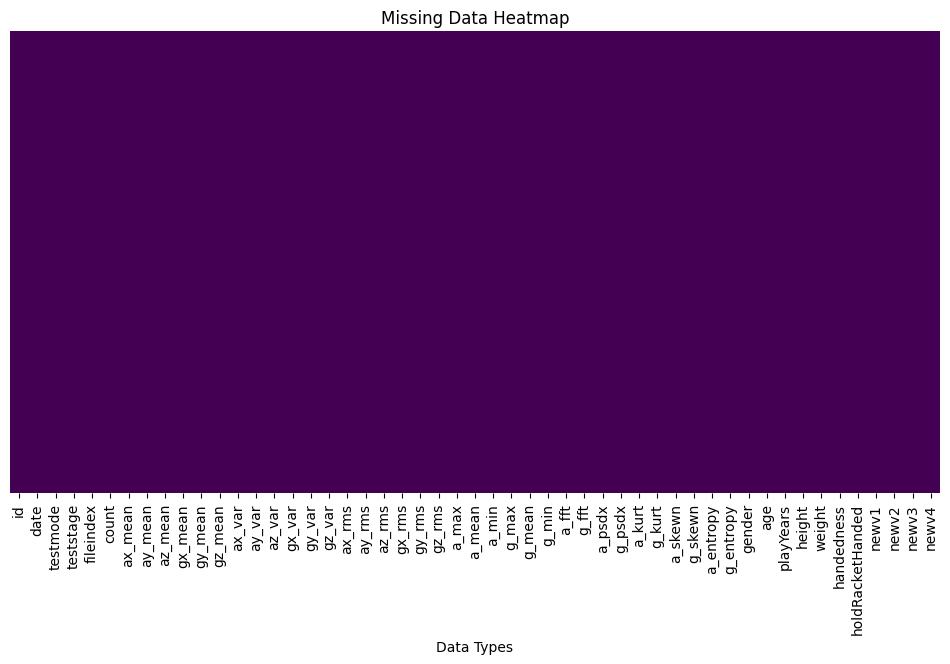

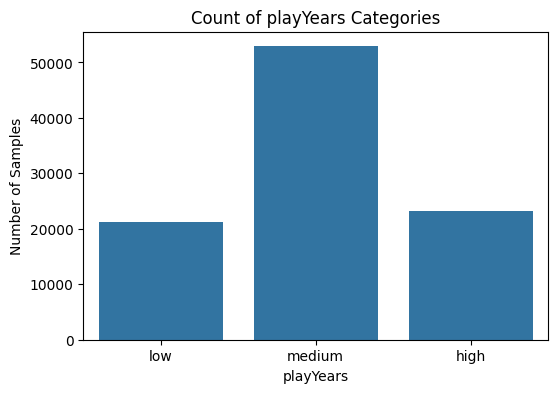

In [5]:
# 1.1.1 Missing‐value heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.xlabel("Data Types")
plt.show()

# 1.1.2 Class distribution for playYears
plt.figure(figsize=(6,4))
sns.countplot(x="playYears", data=df, order=["low","medium","high"])
plt.title("Count of playYears Categories")
plt.ylabel("Number of Samples")
plt.show()

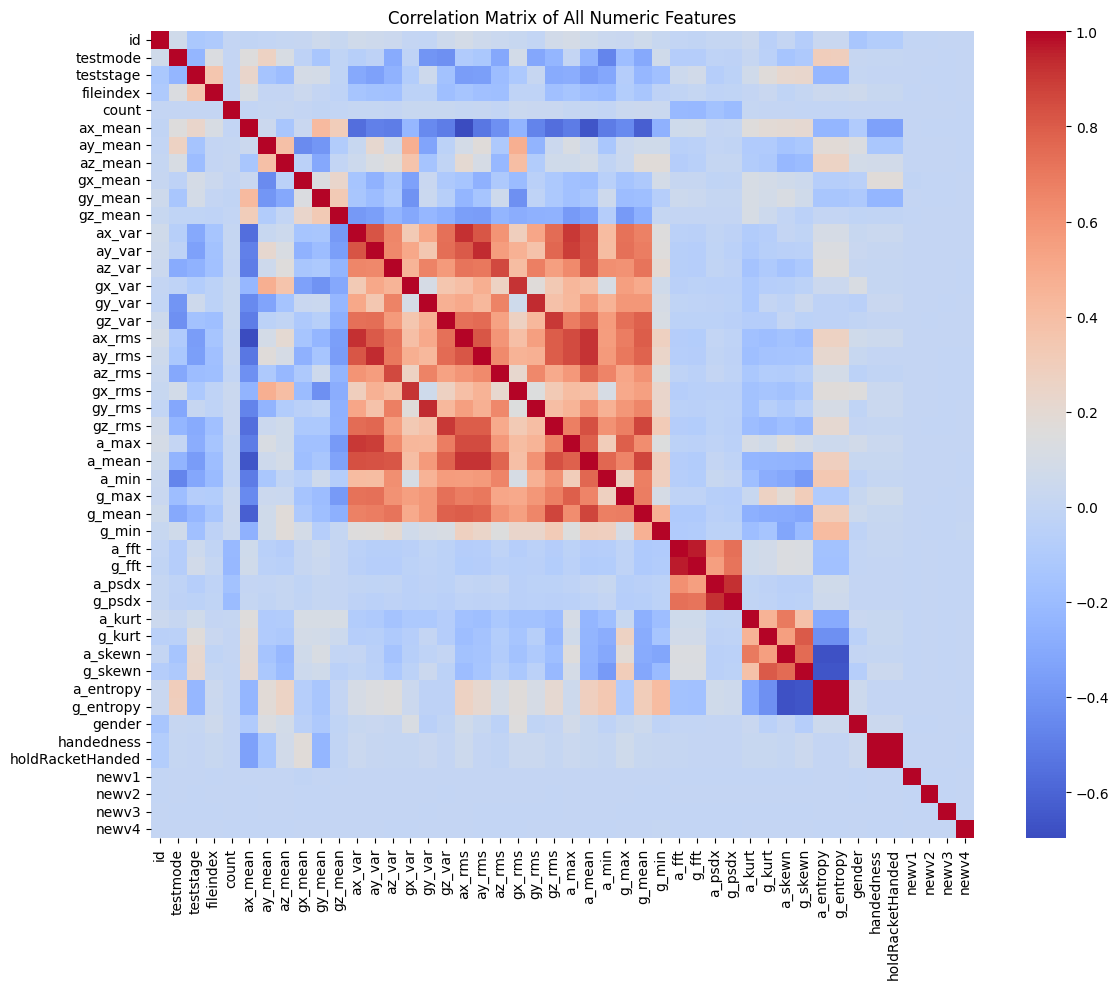

In [6]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    df.select_dtypes(include='number').corr(),
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Correlation Matrix of All Numeric Features")
plt.tight_layout()
plt.show()


                                        check  dropped
0                          sensor non-numeric        0
1                         gender not in [0,1]        0
2                     handedness not in [0,1]        0
3               holdRacketHanded not in [0,1]        0
4        age not in ['low', 'medium', 'high']        5
5  playYears not in ['low', 'medium', 'high']        5
6     height not in ['low', 'medium', 'high']        5
7     weight not in ['low', 'medium', 'high']        5


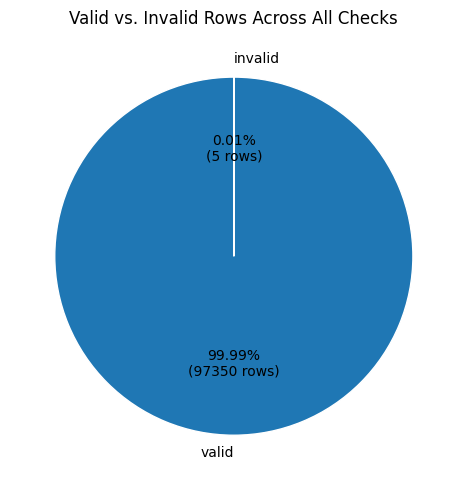

In [7]:
# 0) point this at your DataFrame
df_raw = df.copy()

# 1) define which columns to check
gender_cols = ['gender', 'handedness', 'holdRacketHanded']
cat_cols    = ['age', 'playYears', 'height', 'weight']
valid_levels = ['low', 'medium', 'high']

# 2) sensor columns = all numeric dtypes minus the demographics
sensor_cols = (
    df_raw
    .select_dtypes(include=[np.number])
    .columns
    .difference(gender_cols + cat_cols)
)

# 3) check sensor numeric‐ness (here we just ensure no nulls in those numeric columns)
mask_sensor_valid = df_raw[sensor_cols].notnull().all(axis=1)
invalid_sensor    = (~mask_sensor_valid).sum()

# 4) check binary fields
invalid_binary = {}
for col in gender_cols:
    mask = df_raw[col].isin([0, 1])
    invalid_binary[col] = (~mask).sum()

# 5) check categorical fields
invalid_cat = {}
for col in cat_cols:
    mask = df_raw[col].isin(valid_levels)
    invalid_cat[col] = (~mask).sum()

# 6) assemble summary table
rows = []
rows.append({'check': 'sensor non-numeric', 'dropped': invalid_sensor})
for col, cnt in invalid_binary.items():
    rows.append({'check': f'{col} not in [0,1]', 'dropped': cnt})
for col, cnt in invalid_cat.items():
    rows.append({'check': f'{col} not in {valid_levels}', 'dropped': cnt})

summary = pd.DataFrame(rows)
print(summary)

# 7) overall rows dropped (union of all invalid masks)
invalid_mask = ~mask_sensor_valid
for col in gender_cols:
    invalid_mask |= ~df_raw[col].isin([0, 1])
for col in cat_cols:
    invalid_mask |= ~df_raw[col].isin(valid_levels)

total_invalid = invalid_mask.sum()

# 8) pie‐chart of valid vs invalid
counts = pd.Series({
    'valid'  : len(df_raw) - total_invalid,
    'invalid': total_invalid
})

fig, ax = plt.subplots(figsize=(5,5))
counts.plot.pie(
    ax=ax,
    autopct=lambda p: f"{p:.2f}%\n({int(p/100*counts.sum())} rows)",
    colors=['C0','0.8'],
    startangle=90,
    wedgeprops={'edgecolor':'w'}
)
ax.set_ylabel('')
ax.set_title('Valid vs. Invalid Rows Across All Checks')
plt.tight_layout()
plt.show()

## 1.2

In [8]:

# --- 1. Filter out stray categories ---
valid_levels = ["low","medium","high"]
print("Before filter:", df["playYears"].value_counts())
df = df[df["playYears"].isin(valid_levels)].reset_index(drop=True)
print("After filter: ", df["playYears"].value_counts())

# --- 2. Drop non‐feature columns ---
drop_cols = ["fileindex", "count", "playYears", "date"]
df_clean = df.drop(columns=drop_cols)

# --- 3. Keep only fully‐observed columns (Joel‐style) ---
df_clean = df_clean.loc[:, df_clean.notnull().all()]

# --- 4. Label‐encode all remaining object/categorical columns ---
for col in df_clean.select_dtypes(include=["object","category"]):
    df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))


# --- 5. Build X and y, then split 80/20 stratified ---
X = df_clean.copy()
y = LabelEncoder().fit_transform(df["playYears"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# --- Sanity check ---
print("Final df_clean shape:", df_clean.shape)
print("Kept features:", X.shape[1])
print("Any nulls left?:", X.isnull().any().any())
print("Train class counts:", pd.Series(y_train).value_counts().to_dict())




Before filter: playYears
medium    52900
high      23200
low       21250
???           5
Name: count, dtype: int64
After filter:  playYears
medium    52900
high      23200
low       21250
Name: count, dtype: int64
Final df_clean shape: (97350, 47)
Kept features: 47
Any nulls left?: False
Train class counts: {2: 42320, 0: 18560, 1: 17000}


Invalid labels removed:
 Empty DataFrame
Columns: [count]
Index: []
Total rows removed: 0


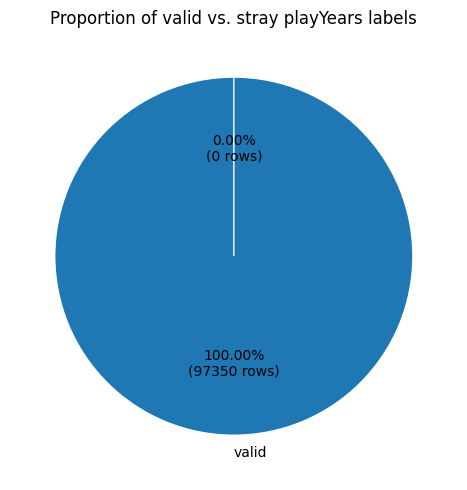

## 1.3

Top10 drifting features: ['gy_mean', 'ay_mean', 'az_mean', 'newv2', 'gender', 'height', 'gx_mean', 'a_fft', 'g_skewn', 'az_rms']


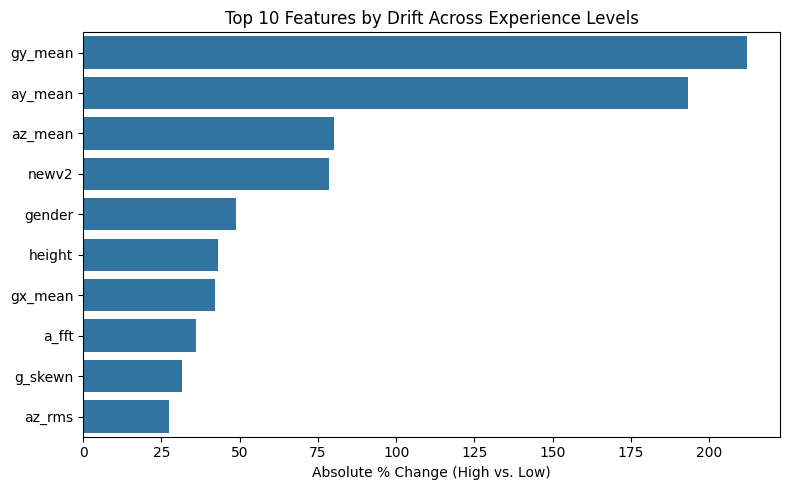

In [8]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# a) Append playYears back onto df_clean for grouping
df_group = df_clean.copy()
df_group["playYears"] = df["playYears"]

# b) Compute group means & percent-change drift
group_means = df_group.groupby("playYears").mean()
pct_change  = ((group_means.loc["high"] - group_means.loc["low"])
               / group_means.loc["low"] * 100).abs()

# c) Pick top-10 drifting features
top10 = pct_change.sort_values(ascending=False).head(10).index.tolist()
print("Top10 drifting features:", top10)

# d) Plot
plt.figure(figsize=(8,5))
sns.barplot(x=pct_change[top10].values, y=top10)
plt.xlabel("Absolute % Change (High vs. Low)")
plt.title("Top 10 Features by Drift Across Experience Levels")
plt.tight_layout()
plt.show()



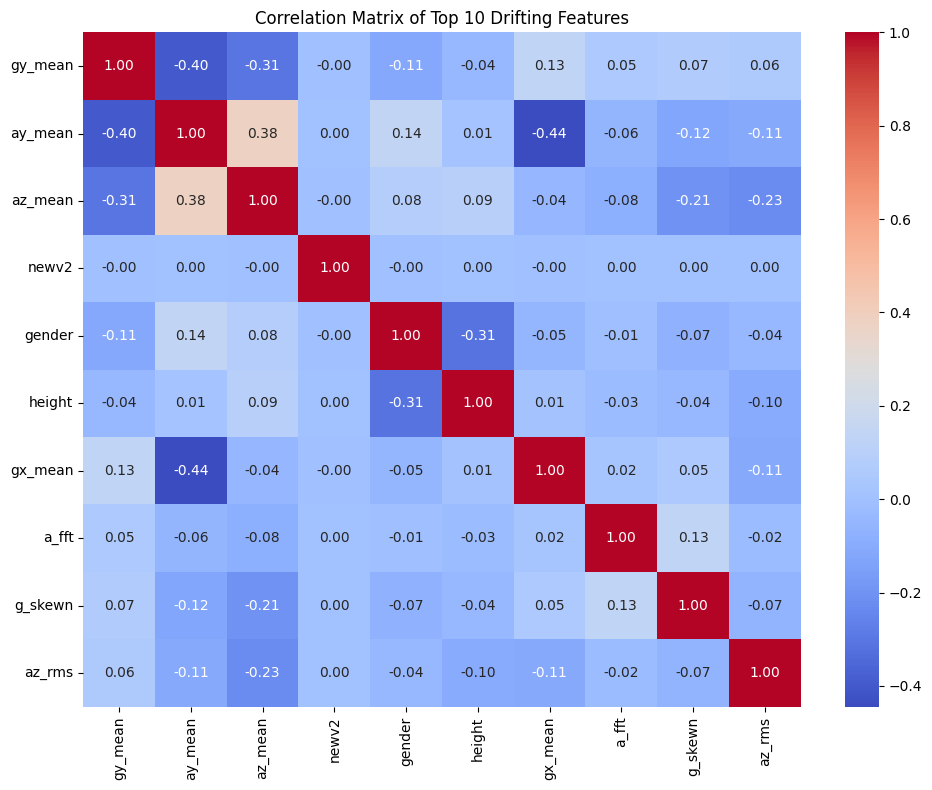

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(X[top10].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Top 10 Drifting Features")
plt.tight_layout()
plt.show()


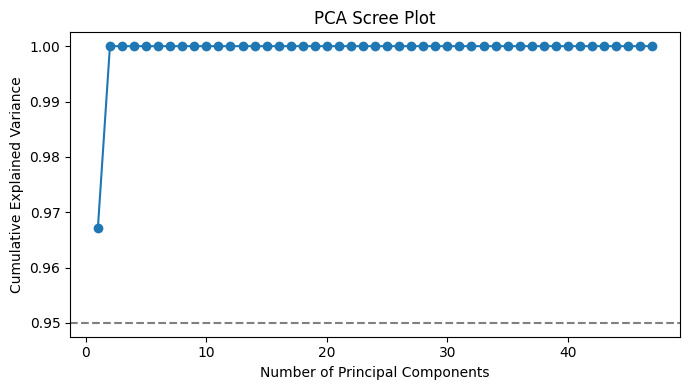

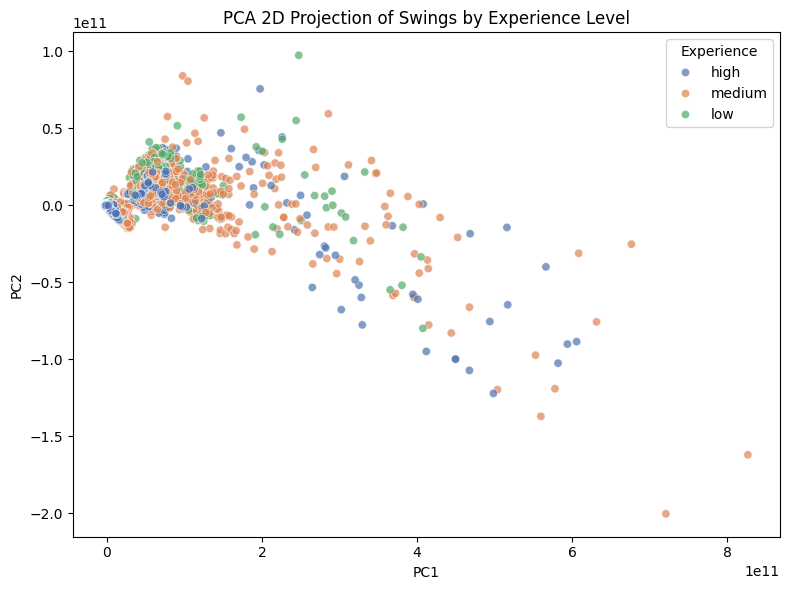

In [10]:
# === 1.3 (revised) Filter & Clean Once, with fresh indexing ===
valid_levels = ["low","medium","high"]
df = df[df["playYears"].isin(valid_levels)].reset_index(drop=True)

# Drop non‐features
df_clean = df.drop(columns=["fileindex","count","playYears","date"])

# Keep only fully observed
df_clean = df_clean.loc[:, df_clean.notnull().all()]

# Label‐encode any cats
from sklearn.preprocessing import LabelEncoder
for col in df_clean.select_dtypes(include=["object","category"]):
    df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))

# Now build X and y_series with the same index
X        = df_clean.reset_index(drop=True)
y_series = df["playYears"].reset_index(drop=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder as LE2

# Encode y for modelling
y = LE2().fit_transform(y_series)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 1) Scree Plot
pca_full = PCA().fit(X)
cumvar   = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(cumvar)+1), cumvar, marker='o')
plt.axhline(0.95, ls='--', color='gray')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.tight_layout()
plt.show()

# 2) 2D Projection
pca2 = PCA(n_components=2)
pc_scores = pca2.fit_transform(X)

proj = pd.DataFrame(pc_scores, columns=["PC1","PC2"])
proj["playYears"] = y_series  # perfect alignment now

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=proj, x="PC1", y="PC2",
    hue="playYears", palette="deep", alpha=0.7
)
plt.title("PCA 2D Projection of Swings by Experience Level")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Experience")
plt.tight_layout()
plt.show()

# Baseline Classifiers


=== Logistic Regression on top-10 features ===
Accuracy: 0.6607

              precision    recall  f1-score   support

        high       0.67      0.63      0.65      4640
         low       0.60      0.36      0.45      4250
      medium       0.67      0.79      0.72     10580

    accuracy                           0.66     19470
   macro avg       0.65      0.60      0.61     19470
weighted avg       0.65      0.66      0.65     19470



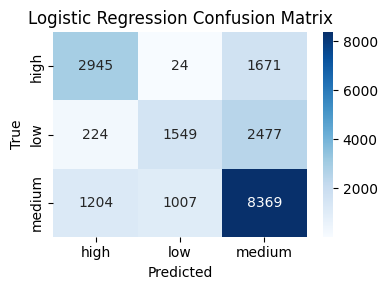


=== KNN (k=5) on top-10 features ===
Accuracy: 0.9758

              precision    recall  f1-score   support

        high       0.98      0.97      0.97      4640
         low       0.97      0.97      0.97      4250
      medium       0.98      0.98      0.98     10580

    accuracy                           0.98     19470
   macro avg       0.98      0.97      0.97     19470
weighted avg       0.98      0.98      0.98     19470



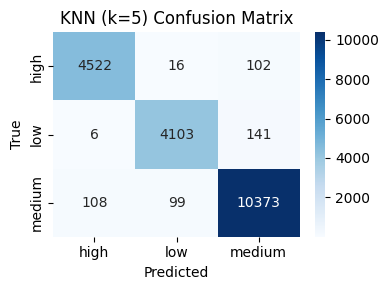

KeyboardInterrupt: 

In [11]:

# 1) Subset to your top-10 features
X_train_sel = X_train.copy()
X_test_sel  = X_test.copy()

# 2) Retrieve your class names
le = LabelEncoder().fit(df["playYears"])
class_names = le.classes_  # e.g. ['high','low','medium']

# 3) Define your pipelines
baseline_models = {
    "Logistic Regression": Pipeline([
        ("scale", StandardScaler()),
        ("clf",   LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "KNN (k=5)"           : Pipeline([
        ("scale", StandardScaler()),
        ("clf",   KNeighborsClassifier(n_neighbors=5))
    ]),
    "Random Forest"       : Pipeline([
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
}

# 4) Train & evaluate
for name, model in baseline_models.items():
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} on top-10 features ===")
    print(f"Accuracy: {acc:.4f}\n")

    # Classification report
    print(classification_report(
        y_test, y_pred,
        labels=le.transform(class_names),
        target_names=class_names
    ))

    # Confusion matrix
    cm = confusion_matrix(
        y_test, y_pred,
        labels=le.transform(class_names)
    )
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()



In [24]:
importances = baseline_models["Random Forest"].named_steps["clf"].feature_importances_
feat_imp = pd.Series(importances, index=top10).sort_values()

plt.figure(figsize=(6,4))
feat_imp.plot.barh()
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances (Top 10)")
plt.tight_layout()
plt.show()


ValueError: Length of values (47) does not match length of index (10)

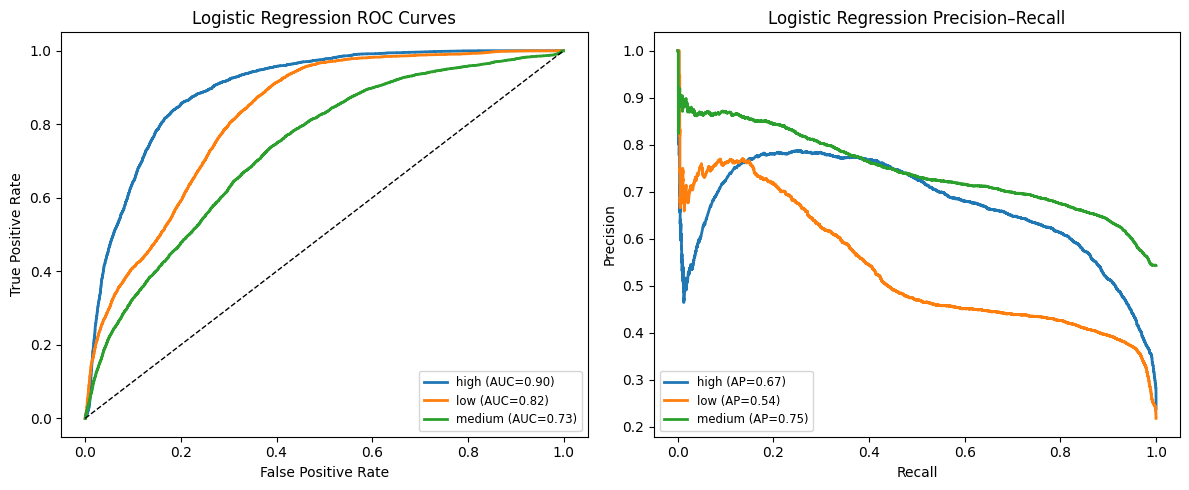

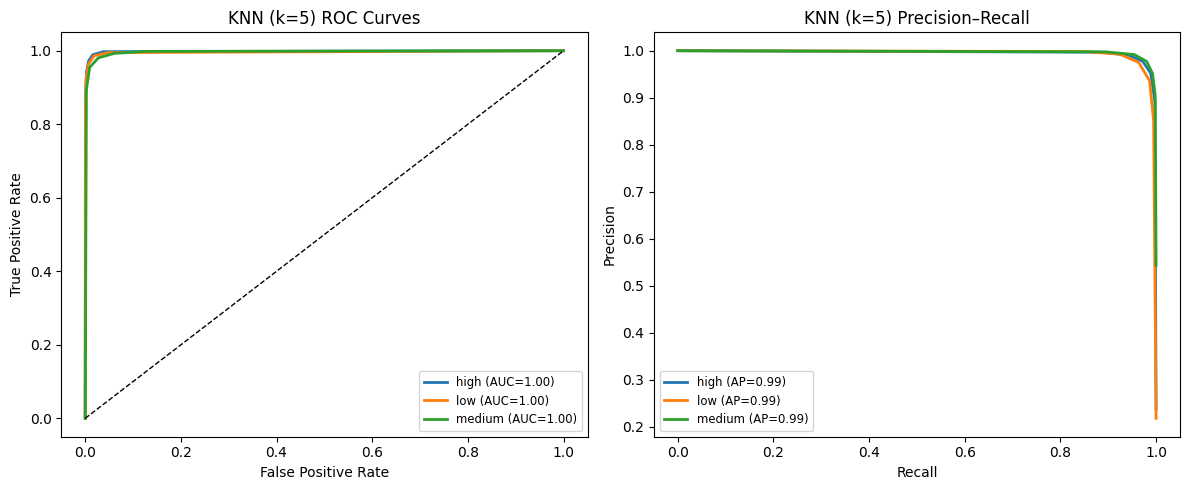

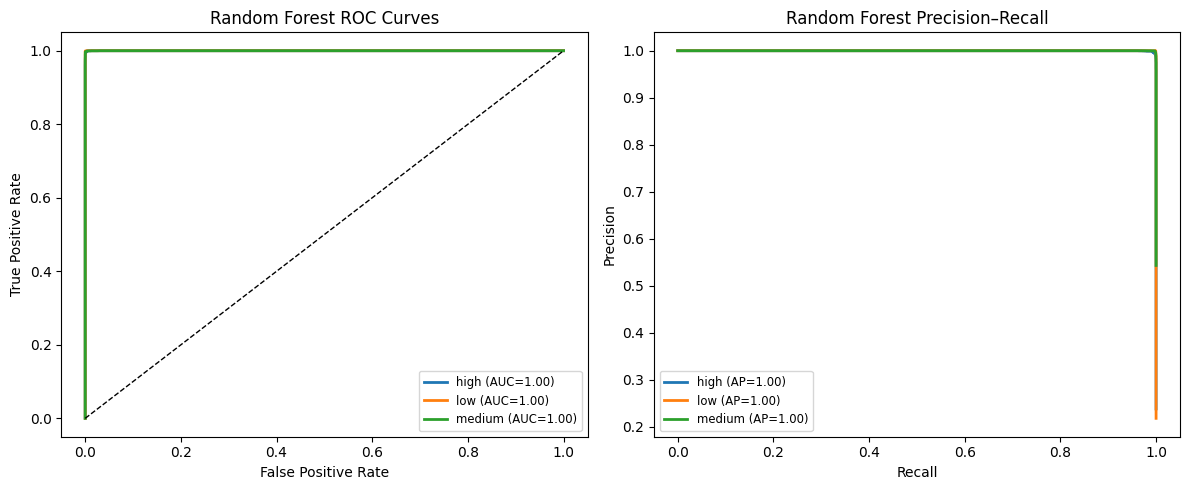

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import label_binarize
from sklearn.metrics       import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)

# Ensure your numeric labels are 0,1,2
# and class_names = le.classes_  (e.g. ['high','low','medium'])
n_classes   = len(class_names)
y_test_bin  = label_binarize(y_test, classes=list(range(n_classes)))

for name, model in baseline_models.items():
    # 1) Get probability scores for each class
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_sel)
    else:
        # some models (like SVC without prob) need decision_function
        y_score = model.decision_function(X_test_sel)
        # then you might normalize to [0,1]
    
    # 2) Make a figure with 2 subplots
    fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(12,5))
    
    # ── ROC Curves ────────────────────────────────────────────────
    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        ax_roc.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={auc(fpr,tpr):.2f})")
    ax_roc.plot([0,1], [0,1], "k--", lw=1)
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title(f"{name} ROC Curves")
    ax_roc.legend(loc="lower right", fontsize="small")
    
    # ── Precision–Recall Curves ────────────────────────────────────
    for i, cls in enumerate(class_names):
        prec, rec, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
        ax_pr.plot(rec, prec, lw=2, label=f"{cls} (AP={ap:.2f})")
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    ax_pr.set_title(f"{name} Precision–Recall")
    ax_pr.legend(loc="lower left", fontsize="small")
    
    plt.tight_layout()
    plt.show()


# Class Imbalance and Smote

In [ ]:
from imblearn.over_sampling import SMOTE

le = LabelEncoder().fit(["high","low","medium"])

# assume X_train, y_train, X_test, y_test are already defined
smote = SMOTE(random_state=42, k_neighbors=5)
X_smote, y_smote = smote.fit_resample(X_train, y_train)


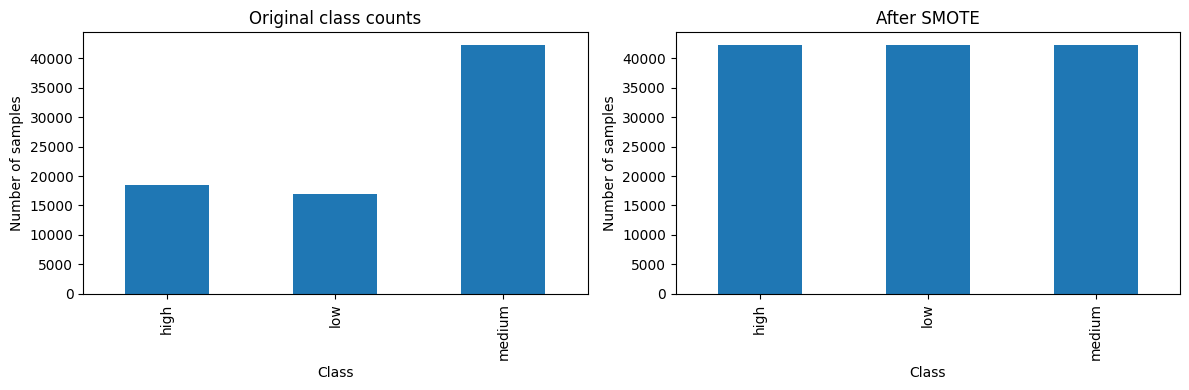

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# count per class
orig_counts = pd.Series(y_train).value_counts().sort_index()
smote_counts = pd.Series(y_smote).value_counts().sort_index()

# 3) Build counts and swap integer index for the string labels
orig_counts  = pd.Series(y_train).value_counts().sort_index()
smote_counts = pd.Series(y_smote).value_counts().sort_index()

orig_counts.index  = le.inverse_transform(orig_counts.index)
smote_counts.index = le.inverse_transform(smote_counts.index)

# plotting
fig, ax = plt.subplots(1,2, figsize=(12,4))
orig_counts.plot.bar(ax=ax[0], title="Original class counts")
smote_counts.plot.bar(ax=ax[1], title="After SMOTE")
for a in ax:
    a.set_xlabel("Class")
    a.set_ylabel("Number of samples")
plt.tight_layout()
plt.show()


# PCA

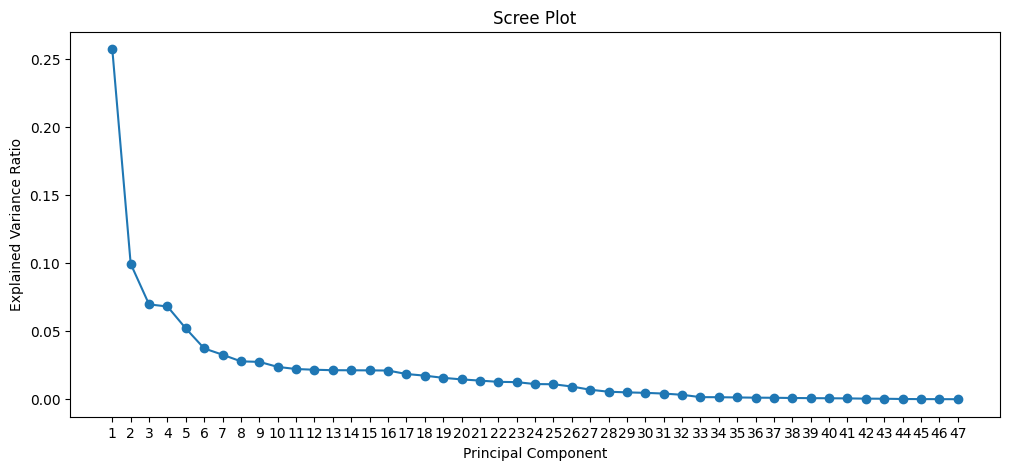

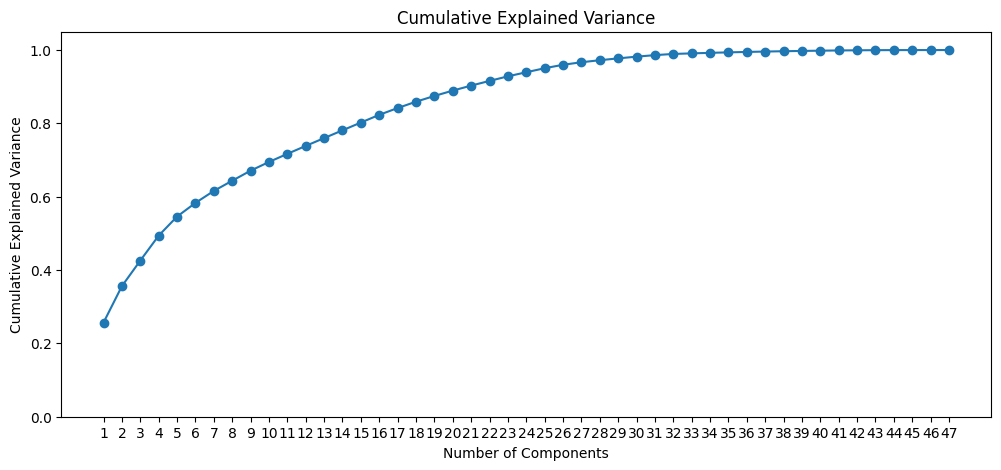

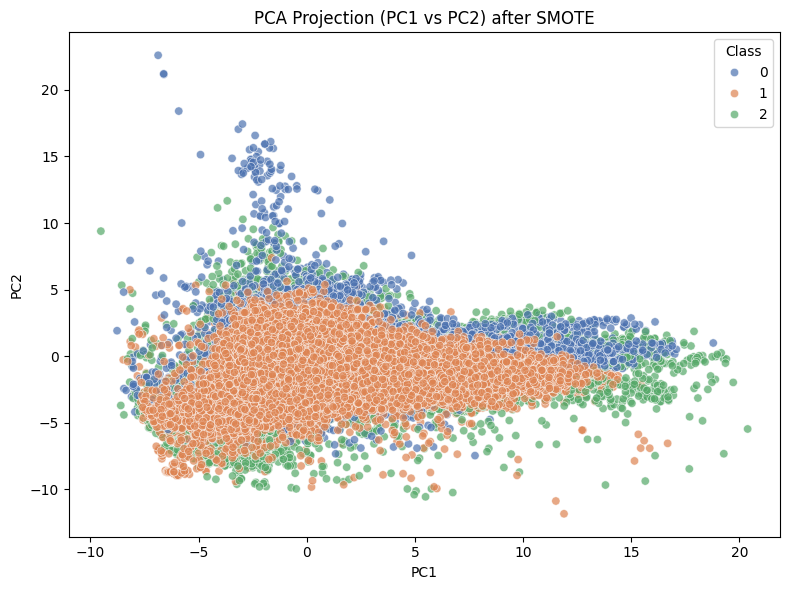

In [ ]:
# --- PCA deliverables on your SMOTE-resampled data ---

# 1) Standardize (again) on X_train_resampled
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_smote)

# 2) Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 3) Scree plot: variance ratio per PC
plt.figure(figsize=(12, 5))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_,
         marker='o', linestyle='-')
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1))
plt.show()

# 4) Cumulative explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 5))
plt.plot(np.arange(1, len(cum_var) + 1),
         cum_var,
         marker='o', linestyle='-')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.xticks(np.arange(1, len(cum_var) + 1))
plt.ylim(0, 1.05)
plt.show()

# 5) 2D projection (PC1 vs PC2)
df_pca = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"])
df_pca["Class"] = y_smote  # adjust name if your target is different

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca,
                x="PC1", y="PC2",
                hue="Class",
                palette="deep",
                alpha=0.7)
plt.title("PCA Projection (PC1 vs PC2) after SMOTE")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Class")
plt.tight_layout()
plt.show()


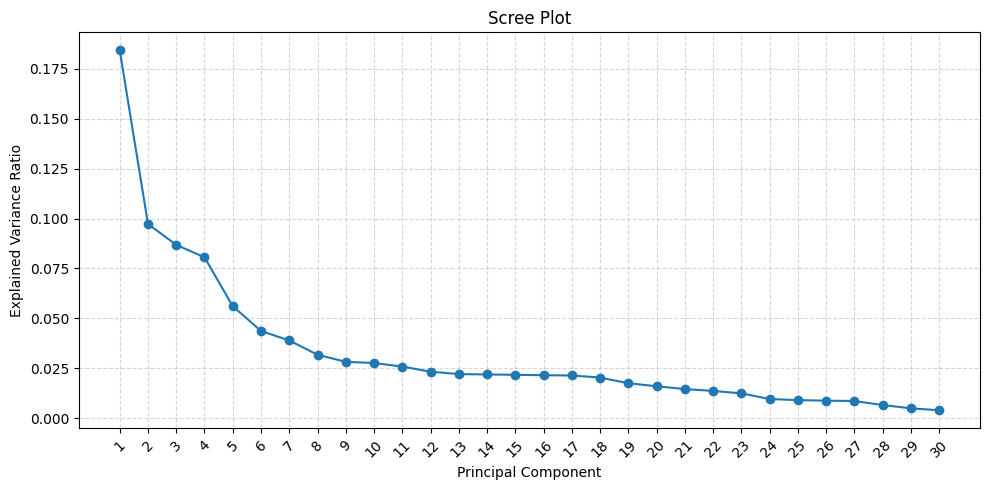

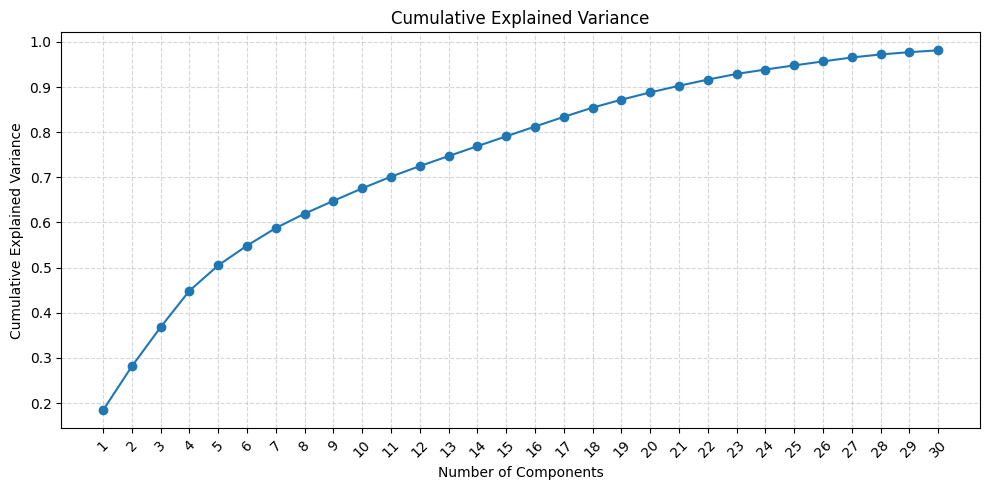

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# replace `pca` with your actual PCA variable (e.g. pca_smote)
explained_var = pca.explained_variance_ratio_
cum_var       = np.cumsum(explained_var)
components    = np.arange(1, len(explained_var) + 1)

# show only the first N components (e.g. 30)
N = min(30, len(components))
comp_disp       = components[:N]
explained_disp  = explained_var[:N]
cumvar_disp     = cum_var[:N]

# Scree plot
plt.figure(figsize=(10,5))
plt.plot(comp_disp, explained_disp, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(comp_disp, rotation=45)
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Cumulative Explained Variance
plt.figure(figsize=(10,5))
plt.plot(comp_disp, cumvar_disp, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(comp_disp, rotation=45)
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Best Basline Model

In [ ]:
# --- 1) Define base classifiers ---
base_models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "RandomForest": RandomForestClassifier(random_state=42),
}

# --- 2) Build pipelines: SMOTE -> Scaling -> PCA(90% var) -> Classifier ---
pipelines = {}
for name, clf in base_models.items():
    pipelines[name] = Pipeline([
        ("smote", SMOTE(random_state=42)),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.80, random_state=42)),
        ("clf", clf),
    ])

# --- 3) Fit each pipeline and evaluate ---
def plot_confusion(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(4,3))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_roc_pr(pipeline, X_test, y_test, classes, title_prefix):
    y_prob = pipeline.predict_proba(X_test)
    y_bin = label_binarize(y_test, classes=classes)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # ROC
    for idx, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, idx], y_prob[:, idx])
        auc = roc_auc_score(y_bin[:, idx], y_prob[:, idx])
        axes[0].plot(fpr, tpr, label=f"{cls} (AUC={auc:.2f})")
    axes[0].plot([0,1], [0,1], 'k--')
    axes[0].set_title(f"{title_prefix} ROC Curves")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].legend()
    # Precision-Recall
    for idx, cls in enumerate(classes):
        prec, rec, _ = precision_recall_curve(y_bin[:, idx], y_prob[:, idx])
        ap = average_precision_score(y_bin[:, idx], y_prob[:, idx])
        axes[1].plot(rec, prec, label=f"{cls} (AP={ap:.2f})")
    axes[1].set_title(f"{title_prefix} Precision–Recall")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].legend()
    plt.tight_layout()
    plt.show()

classes = np.unique(y_train)

for name, pipe in pipelines.items():
    print(f"\n=== {name} pipeline (SMOTE + PCA) ===")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    plot_confusion(y_test, y_pred, classes, f"{name} Confusion Matrix")
    plot_roc_pr(pipe, X_test, y_test, classes, name)


=== LogisticRegression pipeline (SMOTE + PCA) ===


TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(random_state=42)' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't


>>> LogisticRegression (SMOTE + PCA) <<<


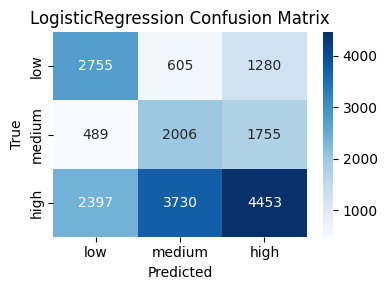

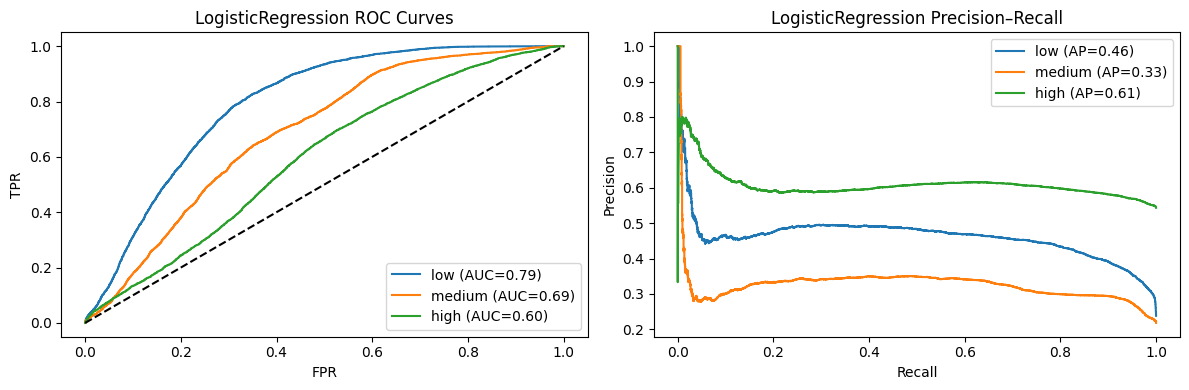

PCA reduced from 47 → 15 features

>>> KNN (SMOTE + PCA) <<<


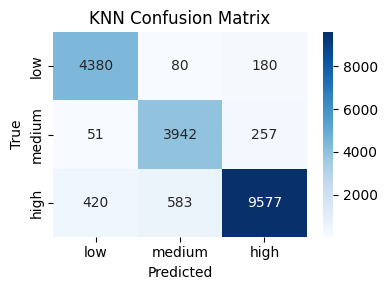

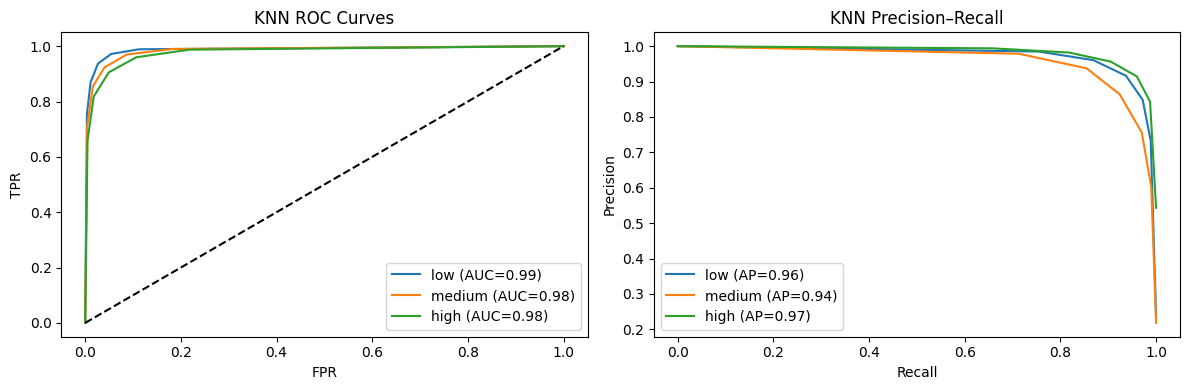

PCA reduced from 47 → 15 features

>>> RandomForest (SMOTE + PCA) <<<


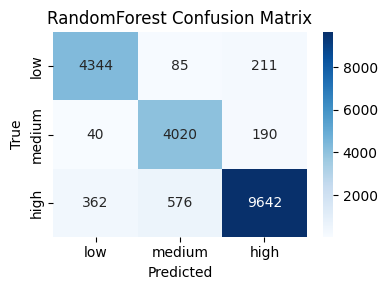

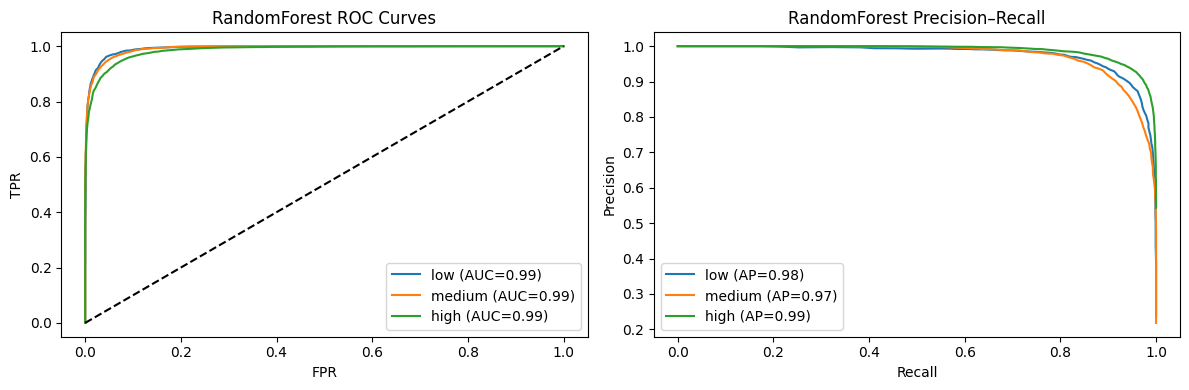

PCA reduced from 47 → 15 features


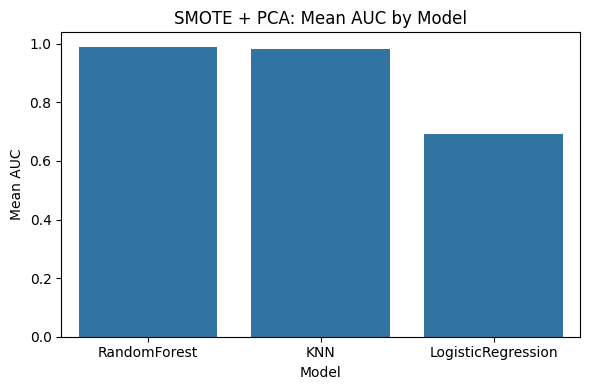

,Model,Mean AUC,Mean AP
2,RandomForest,0.989776,0.978937
1,KNN,0.982719,0.958004
0,LogisticRegression,0.692382,0.465655


In [22]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing   import StandardScaler, label_binarize
from sklearn.decomposition    import PCA
from sklearn.linear_model     import LogisticRegression
from sklearn.neighbors        import KNeighborsClassifier
from sklearn.ensemble         import RandomForestClassifier
from sklearn.metrics          import (
    confusion_matrix, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# — 0) Define your numeric codes and display names —
labels      = [0, 1, 2]
class_names = ['low', 'medium', 'high']

# — 1) Base classifiers —
base_models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN":                KNeighborsClassifier(n_neighbors=5),
    "RandomForest":       RandomForestClassifier(random_state=42),
}

# — 2) SMOTE → Scale → PCA → Classifier pipelines —
pipelines = {}
for name, clf in base_models.items():
    pipelines[name] = Pipeline([
        ("smote", SMOTE(random_state=42)),
        ("scale", StandardScaler()),
        ("pca",   PCA(n_components=0.80, random_state=42)),
        ("clf",   clf),
    ])

# — Helper: plot confusion matrix with class_names —
def plot_confusion(y_true, y_pred, title):
    cm    = confusion_matrix(y_true, y_pred, labels=labels)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(4,3))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# — Helper: plot ROC & Precision–Recall using class_names —
def plot_roc_pr(pipe, X_test, y_test, prefix):
    # 1) get probabilities and binarize y
    y_prob = pipe.predict_proba(X_test)
    y_bin  = label_binarize(y_test, classes=labels)

    fig, ax = plt.subplots(1,2, figsize=(12,4))

    # — ROC curves —
    for i, name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_bin[:,i], y_prob[:,i])
        auc = roc_auc_score(y_bin[:,i], y_prob[:,i])
        ax[0].plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
    ax[0].plot([0,1],[0,1],'k--')
    ax[0].set(title=f"{prefix} ROC Curves", xlabel="FPR", ylabel="TPR")
    ax[0].legend()

    # — Precision–Recall curves —
    for i, name in enumerate(class_names):
        prec, rec, _ = precision_recall_curve(y_bin[:,i], y_prob[:,i])
        ap = average_precision_score(y_bin[:,i], y_prob[:,i])
        ax[1].plot(rec, prec, label=f"{name} (AP={ap:.2f})")
    ax[1].set(title=f"{prefix} Precision–Recall", xlabel="Recall", ylabel="Precision")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# — 3) Fit each pipeline, show plots, collect metrics —
summary = []
for name, pipe in pipelines.items():
    print(f"\n>>> {name} (SMOTE + PCA) <<<")
    pipe.fit(X_train, y_train)            # y_train contains 0,1,2
    y_pred = pipe.predict(X_test)

    # confusion
    plot_confusion(y_test, y_pred, f"{name} Confusion Matrix")

    # ROC & PR
    plot_roc_pr(pipe, X_test, y_test, name)

    # mean AUC & AP
    y_prob = pipe.predict_proba(X_test)
    y_bin  = label_binarize(y_test, classes=labels)
    aucs   = [roc_auc_score(y_bin[:,i], y_prob[:,i]) for i in range(len(labels))]
    aps    = [average_precision_score(y_bin[:,i], y_prob[:,i]) for i in range(len(labels))]
    summary.append({"Model": name, "Mean AUC": np.mean(aucs), "Mean AP": np.mean(aps)})

    # PCA reduction report
    n_comp = pipe.named_steps["pca"].n_components_
    print(f"PCA reduced from {X_train.shape[1]} → {n_comp} features")

# — 4) Summary table & bar chart —
df_summary = pd.DataFrame(summary).sort_values("Mean AUC", ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x="Model", y="Mean AUC", data=df_summary)
plt.title("SMOTE + PCA: Mean AUC by Model")
plt.tight_layout()
plt.show()

df_summary



In [16]:
import time
from sklearn.utils import Bunch  # just a placeholder

# Pick one random hyperparameter setting
from scipy.stats import randint
from sklearn.model_selection import ParameterSampler
rf_pipe = pipelines["RandomForest"]
param_dist = {
    "clf__n_estimators": randint(100, 501),
    "clf__max_depth":    [None,10,20,30],
    "clf__min_samples_split": randint(2,11),
    "clf__min_samples_leaf":  randint(1,5),
    "clf__max_features":   ["sqrt","log2",0.2,0.5]
}

# draw exactly one setting
one_params = list(ParameterSampler(param_dist, n_iter=1, random_state=0))[0]

# configure the pipeline
rf_pipe.set_params(**one_params)

# measure
start = time.time()
rf_pipe.fit(X_train, y_train)
elapsed = time.time() - start
print(f"Single fit took {elapsed:.1f}s")

# estimate total: n_iter * cv_folds / n_jobs
n_iter    = 50
cv_folds  = 5
n_jobs    = -1  # if you’re saturating all cores, assume linear speedup
estimated = elapsed * n_iter * cv_folds / abs(n_jobs)
print(f"Estimated total time: {estimated/60:.1f} minutes")

Single fit took 520.9s
Estimated total time: 2170.3 minutes


In [ ]:
import time
from sklearn.model_selection import ParameterSampler

# draw 5 random hyperparameter settings
param_dist = {
    "clf__n_estimators": [100,200,500],
    "clf__max_depth":    [None,10,20,30],
    "clf__min_samples_split": [2,5,10],
    "clf__min_samples_leaf":  [1,2,4],
    "clf__max_features":   ["sqrt","log2",0.2,0.5]
}
sampler = list(ParameterSampler(param_dist, n_iter=5, random_state=0))

times = []
for params in sampler:
    rf_pipe.set_params(**params)
    start = time.time()
    rf_pipe.fit(X_train, y_train)    # with cv=3 or your planned CV
    times.append(time.time() - start)

avg = sum(times)/len(times)
print(f"Avg fit time (for one fold): {avg:.1f}s")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [ ]:
(avg) × (number of folds) × (number of candidate settings) / n_jobs

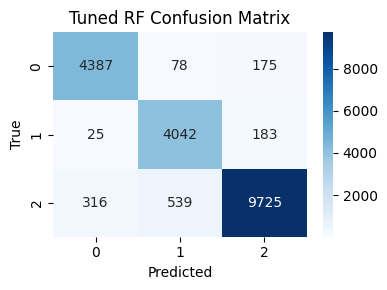

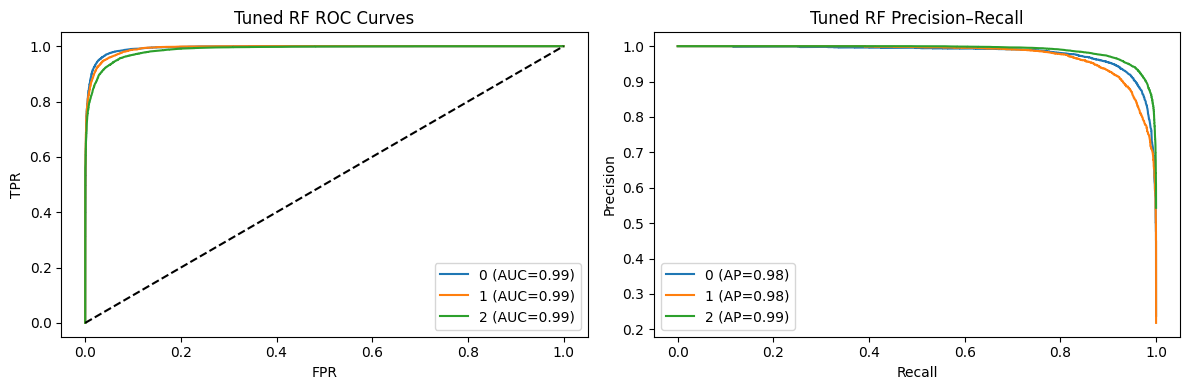

Test-set accuracy: 0.9324



TypeError: object of type 'numpy.int64' has no len()

In [20]:
# --- 1) Inject best params into the RandomForest pipeline ---
best_params = {
    "clf__n_estimators":     413,
    "clf__max_depth":        30,
    "clf__min_samples_split": 2,
    "clf__min_samples_leaf":  1,
    "clf__max_features":     0.5
}

rf_pipe = pipelines["RandomForest"]
rf_pipe.set_params(**best_params)

# --- 2) Fit on the full training set ---
rf_pipe.fit(X_train, y_train)

# --- 3) Predict on the test set ---
y_pred = rf_pipe.predict(X_test)
y_prob = rf_pipe.predict_proba(X_test)

# --- 4) Confusion matrix ---
plot_confusion(y_test, y_pred, labels, "Tuned RF Confusion Matrix")

# --- 5) ROC & Precision–Recall curves ---
plot_roc_pr(rf_pipe, X_test, y_test, labels, "Tuned RF")

# --- 6) Summary metrics ---
from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(y_test, y_pred)
print(f"Test-set accuracy: {acc:.4f}\n")
print("Classification report:\n", classification_report(y_test, y_pred, target_names=labels))

# Optional: update your summary table
summary.append({
    "Model": "Tuned RF",
    "Mean AUC": np.mean([roc_auc_score(label_binarize(y_test, classes=labels)[:,i], y_prob[:,i]) 
                        for i in range(len(labels))]),
    "Mean AP":  np.mean([average_precision_score(label_binarize(y_test, classes=labels)[:,i], y_prob[:,i]) 
                        for i in range(len(labels))])
})
df_summary = pd.DataFrame(summary).sort_values("Mean AUC", ascending=False)
print(df_summary)


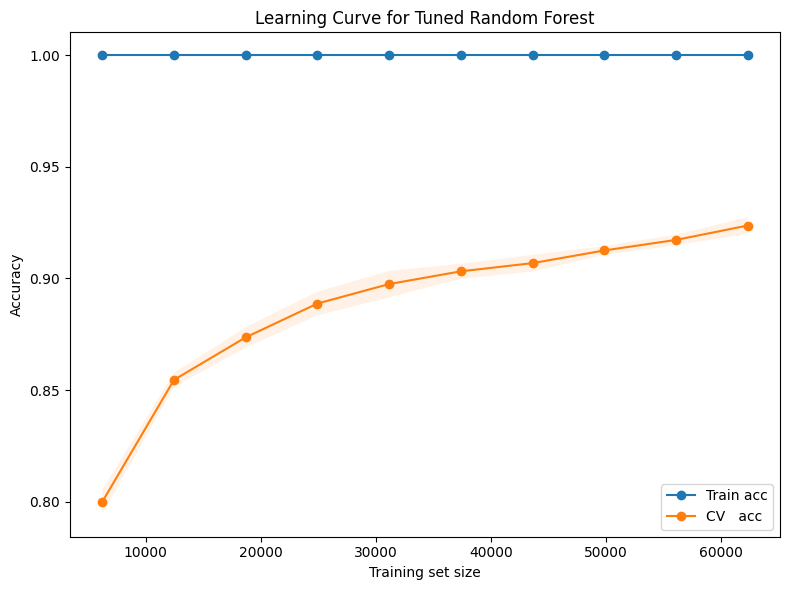

In [24]:
from sklearn.model_selection import learning_curve
# Use the tuned pipeline (with best_params already set)
pipe = rf_pipe  

# Compute learning curve
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=pipe,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Compute means & stds
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores,  axis=1)
cv_mean    = np.mean(cv_scores,    axis=1)
cv_std     = np.std(cv_scores,     axis=1)

# Plot
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label='Train acc')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.plot(train_sizes, cv_mean,    'o-', label='CV   acc')
plt.fill_between(train_sizes, cv_mean-cv_std,    cv_mean+cv_std,    alpha=0.1)
plt.title("Learning Curve for Tuned Random Forest")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Basic Neural Net

Epoch  1 | Train loss=0.281, acc=0.840 | Val   loss=0.110, acc=0.940
Epoch  2 | Train loss=0.117, acc=0.940 | Val   loss=0.075, acc=0.959
Epoch  3 | Train loss=0.085, acc=0.957 | Val   loss=0.048, acc=0.973
Epoch  4 | Train loss=0.070, acc=0.964 | Val   loss=0.037, acc=0.981
Epoch  5 | Train loss=0.063, acc=0.968 | Val   loss=0.037, acc=0.980
Epoch  6 | Train loss=0.057, acc=0.971 | Val   loss=0.029, acc=0.984
Epoch  7 | Train loss=0.050, acc=0.974 | Val   loss=0.026, acc=0.987
Epoch  8 | Train loss=0.049, acc=0.976 | Val   loss=0.022, acc=0.989
Epoch  9 | Train loss=0.045, acc=0.978 | Val   loss=0.021, acc=0.991
Epoch 10 | Train loss=0.045, acc=0.978 | Val   loss=0.020, acc=0.990
Epoch 11 | Train loss=0.041, acc=0.979 | Val   loss=0.018, acc=0.991
Epoch 12 | Train loss=0.040, acc=0.981 | Val   loss=0.020, acc=0.989
Epoch 13 | Train loss=0.040, acc=0.981 | Val   loss=0.016, acc=0.992
Epoch 14 | Train loss=0.036, acc=0.982 | Val   loss=0.018, acc=0.991
Epoch 15 | Train loss=0.036, acc=0

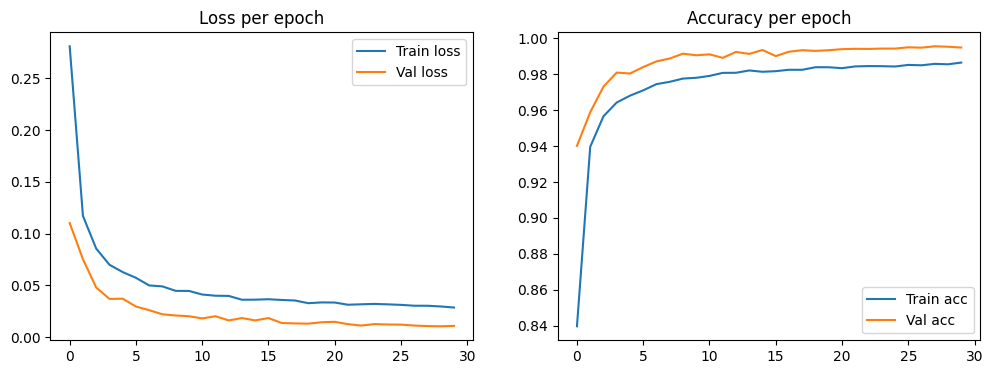

Confusion Matrix:
 [[ 4627     3    10]
 [    0  4249     1]
 [   81    18 10481]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      4640
           1       1.00      1.00      1.00      4250
           2       1.00      0.99      0.99     10580

    accuracy                           0.99     19470
   macro avg       0.99      1.00      0.99     19470
weighted avg       0.99      0.99      0.99     19470



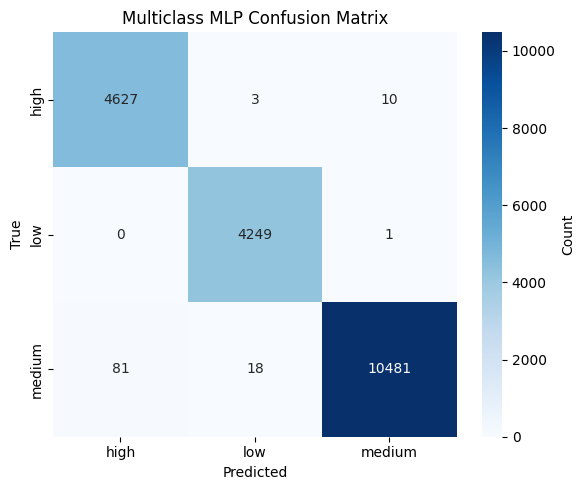

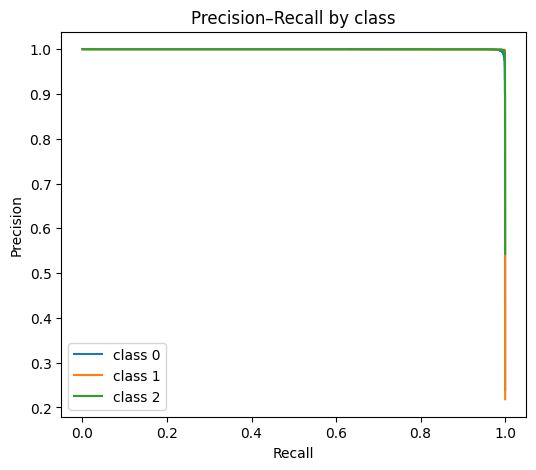

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Prepare data arrays (make sure X_train, y_train, X_test, y_test are numpy arrays) ---
# stratify to keep class proportions in your validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train if isinstance(X_train, np.ndarray) else X_train.values,
    y_train if isinstance(y_train, np.ndarray) else y_train.values,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)
X_te = X_test if isinstance(X_test, np.ndarray) else X_test.values
y_te = y_test if isinstance(y_test, np.ndarray) else y_test.values

# --- 2) Standardize ---
scaler       = StandardScaler()
X_tr_scaled  = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)
X_te_scaled  = scaler.transform(X_te)

# --- 3) SMOTE on the training split only ---
sm = SMOTE(random_state=42, k_neighbors=5)
X_tr_res, y_tr_res = sm.fit_resample(X_tr_scaled, y_tr)

# --- 4) Wrap into PyTorch datasets & loaders ---
train_ds     = TensorDataset(
    torch.from_numpy(X_tr_res).float(),
    torch.from_numpy(y_tr_res).long()
)
val_ds       = TensorDataset(
    torch.from_numpy(X_val_scaled).float(),
    torch.from_numpy(y_val).long()
)
test_ds      = TensorDataset(
    torch.from_numpy(X_te_scaled).float(),
    torch.from_numpy(y_te).long()
)

batch_size   = 64
train_loader = DataLoader(train_ds,   batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,     batch_size=batch_size)
test_loader  = DataLoader(test_ds,    batch_size=batch_size)

# 4) DataLoaders
batch_size   = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)
# --- 2) Define a deeper MLP with Dropout ---
class DeepMLP(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, num_classes, p_dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(p_dropout),

            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(p_dropout),

            nn.Linear(hidden2, num_classes)
        )
    def forward(self, x):
        return self.net(x)

input_dim = X_tr.shape[1]
hidden1     = 128
hidden2     = 64
num_classes = len(np.unique(y_tr))

model = DeepMLP(input_dim, hidden1, hidden2, num_classes, p_dropout=0.3)

# --- 3) Use class-weighted CrossEntropyLoss to up-weight rare classes ---
class_counts = np.bincount(y_tr)
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- 4) Training loop (30 epochs) ---
epochs = 30
train_losses, val_losses = [], []
train_accs,  val_accs   = [], []

for ep in range(1, epochs+1):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(Xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*yb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds==yb).sum().item()
        total   += yb.size(0)
    train_losses.append(running_loss/total)
    train_accs.append(correct/total)

    # -- validation --
    model.eval()
    v_loss, v_c, v_t = 0, 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            logits = model(Xb)
            v_loss += criterion(logits, yb).item()*yb.size(0)
            preds = logits.argmax(dim=1)
            v_c += (preds==yb).sum().item()
            v_t += yb.size(0)
    val_losses.append(v_loss/v_t)
    val_accs.append(v_c/v_t)

    print(f"Epoch {ep:2d} | "
          f"Train loss={train_losses[-1]:.3f}, acc={train_accs[-1]:.3f} | "
          f"Val   loss={val_losses[-1]:.3f}, acc={val_accs[-1]:.3f}")

# --- 5) Plot training/validation curves ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses,   label='Val loss')
plt.legend(); plt.title("Loss per epoch")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train acc')
plt.plot(val_accs,   label='Val acc')
plt.legend(); plt.title("Accuracy per epoch")
plt.show()

# --- 6) Final test evaluation & PR curves ---
model.eval()
all_preds, all_probs, all_true = [], [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        logits = model(Xb)
        all_probs.append(torch.softmax(logits, dim=1).cpu().numpy())
        all_preds.append(logits.argmax(dim=1).cpu().numpy())
        all_true.append(yb.cpu().numpy())

all_probs = np.vstack(all_probs)
all_preds = np.concatenate(all_preds)
all_true  = np.concatenate(all_true)

# Confusion matrix & classification report
cm = confusion_matrix(all_true, all_preds)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n",
      classification_report(all_true, all_preds))
class_names = ['high','low','medium']   # adjust order to match your label encoding

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label':'Count'}
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Multiclass MLP Confusion Matrix")
plt.tight_layout()
plt.show()

# Precision–Recall curves
plt.figure(figsize=(6,5))
for cls in range(num_classes):
    precision, recall, _ = precision_recall_curve(
        (all_true==cls).astype(int),
        all_probs[:,cls]
    )
    plt.plot(recall, precision, label=f"class {cls}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.title("Precision–Recall by class")
plt.show()


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train if isinstance(X_train, np.ndarray) else X_train.values,
    y_train if isinstance(y_train, np.ndarray) else y_train.values,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)
X_te = X_test if isinstance(X_test, np.ndarray) else X_test.values
y_te = y_test if isinstance(y_test, np.ndarray) else y_test.values

# --- 2) Standardize ---
scaler       = StandardScaler()
X_tr_scaled  = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)
X_te_scaled  = scaler.transform(X_te)

# --- 3) SMOTE on the training split only ---
sm = SMOTE(random_state=42, k_neighbors=5)
X_tr_res, y_tr_res = sm.fit_resample(X_tr_scaled, y_tr)

# --- 4) Wrap into PyTorch datasets & loaders ---
train_ds     = TensorDataset(
    torch.from_numpy(X_tr_res).float(),
    torch.from_numpy(y_tr_res).long()
)
val_ds       = TensorDataset(
    torch.from_numpy(X_val_scaled).float(),
    torch.from_numpy(y_val).long()
)
test_ds      = TensorDataset(
    torch.from_numpy(X_te_scaled).float(),
    torch.from_numpy(y_te).long()
)

batch_size   = 64
train_loader = DataLoader(train_ds,   batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,     batch_size=batch_size)
test_loader  = DataLoader(test_ds,    batch_size=batch_size)

# 4) DataLoaders
batch_size   = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

# --- 2) Define 1D CNN ---
class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, 3, padding=1)
        self.pool  = nn.MaxPool1d(2)
        # compute flattened size after two poolings
        flat_size = 32 * (input_dim // 2 // 2)
        self.fc1 = nn.Linear(flat_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # x: (batch, features) → (batch, 1, features)
        x = x.unsqueeze(1)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

input_dim   = X_tr.shape[1]
num_classes = len(np.unique(y_tr))
model = CNN1D(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- 3) Training loop ---
epochs = 20
train_losses, val_losses = [], []
train_accs,  val_accs   = [], []

for epoch in range(1, epochs+1):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(Xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * len(yb)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total   += len(yb)
    train_losses.append(running_loss/total)
    train_accs.append(correct/total)

    model.eval()
    v_loss, v_c, v_t = 0,0,0
    with torch.no_grad():
        for Xb, yb in val_loader:
            logits = model(Xb)
            v_loss += criterion(logits, yb).item() * len(yb)
            preds   = logits.argmax(dim=1)
            v_c    += (preds == yb).sum().item()
            v_t    += len(yb)
    val_losses.append(v_loss/v_t)
    val_accs.append(v_c/v_t)

    print(f"Epoch {epoch:2d} | Train loss={train_losses[-1]:.4f}, acc={train_accs[-1]:.4f} | "
          f"Val loss={val_losses[-1]:.4f}, acc={val_accs[-1]:.4f}")

# plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses,   label='Val loss')
plt.title("Loss per epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train acc')
plt.plot(val_accs,   label='Val acc')
plt.title("Accuracy per epoch")
plt.legend()
plt.show()

# --- 4) Test set evaluation ---
model.eval()
all_logits, all_true = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        all_logits.append(model(Xb).cpu())
        all_true.append(yb.cpu())
all_logits = torch.cat(all_logits)
all_true   = torch.cat(all_true)
all_preds  = all_logits.argmax(dim=1).numpy()
all_probs  = nn.functional.softmax(all_logits, dim=1).numpy()

# confusion matrix & report
cm = confusion_matrix(all_true.numpy(), all_preds)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(all_true.numpy(), all_preds))
# if you have human-readable class names, e.g.
class_names = ['high','low','medium']   # adjust order to match your label encoding

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label':'Count'}
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("1D-CNN Confusion Matrix")
plt.tight_layout()
plt.show()

# precision-recall curves
# precision–recall curves with real labels
plt.figure(figsize=(8,6))
class_names = ['low','medium','high']   # must match your encoding order
for cls in range(num_classes):
    precision, recall, _ = precision_recall_curve(
        (all_true.numpy()==cls).astype(int),
        all_probs[:, cls]
    )
    plt.plot(recall, precision, label=class_names[cls])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend(title="Class")
plt.tight_layout()
plt.show()



Epoch  1 | Train loss=0.3182, acc=0.8698 | Val loss=0.1046, acc=0.9654
Epoch  2 | Train loss=0.0576, acc=0.9815 | Val loss=0.0648, acc=0.9786
Epoch  3 | Train loss=0.0261, acc=0.9918 | Val loss=0.0278, acc=0.9915
Epoch  4 | Train loss=0.0166, acc=0.9951 | Val loss=0.0278, acc=0.9921


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

feature_names = X_train.columns.tolist()

# --- 1) Split & numpy conversion ---
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train if isinstance(X_train, np.ndarray) else X_train.values,
    y_train if isinstance(y_train, np.ndarray) else y_train.values,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)
X_te = X_test if isinstance(X_test, np.ndarray) else X_test.values
y_te = y_test if isinstance(y_test, np.ndarray) else y_test.values

# --- 2) Standardize ---
scaler       = StandardScaler()
X_tr_scaled  = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)
X_te_scaled  = scaler.transform(X_te)

# --- 3) SMOTE on training only ---
sm = SMOTE(random_state=42, k_neighbors=5)
X_tr_res, y_tr_res = sm.fit_resample(X_tr_scaled, y_tr)

# --- 4) TensorDatasets & DataLoaders ---
train_ds     = TensorDataset(
    torch.from_numpy(X_tr_res).float(),
    torch.from_numpy(y_tr_res).long()
)
val_ds       = TensorDataset(
    torch.from_numpy(X_val_scaled).float(),
    torch.from_numpy(y_val).long()
)
test_ds      = TensorDataset(
    torch.from_numpy(X_te_scaled).float(),
    torch.from_numpy(y_te).long()
)

batch_size   = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

print("CNN input features (in order):")
for idx, name in enumerate(feature_names):
    print(f"{idx:2d} → {name}")

# --- 5) Define 1D-CNN with 3 blocks, BN, Dropout ---
class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes, p_drop=0.3):
        super().__init__()
        # conv blocks: in→16, 16→32, 32→64
        self.conv1    = nn.Conv1d(1, 16,  kernel_size=3, padding=1)
        self.bn1      = nn.BatchNorm1d(16)
        self.drop1    = nn.Dropout(p_drop)

        self.conv2    = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn2      = nn.BatchNorm1d(32)
        self.drop2    = nn.Dropout(p_drop)

        self.conv3    = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3      = nn.BatchNorm1d(64)
        self.drop3    = nn.Dropout(p_drop)

        self.pool     = nn.MaxPool1d(2)
        self.relu     = nn.ReLU()

        # after three poolings: length → input_dim/2/2/2
        flat_size = 64 * (input_dim // 8)
        self.fc1      = nn.Linear(flat_size, 128)
        self.drop_fc  = nn.Dropout(p_drop)
        self.fc2      = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, features) → (B,1,features)

        x = self.pool(self.drop1(self.relu(self.bn1(self.conv1(x)))))
        x = self.pool(self.drop2(self.relu(self.bn2(self.conv2(x)))))
        x = self.pool(self.drop3(self.relu(self.bn3(self.conv3(x)))))

        x = x.view(x.size(0), -1)          # flatten
        x = self.drop_fc(self.relu(self.fc1(x)))
        return self.fc2(x)                 # raw logits

input_dim   = X_tr_res.shape[1]
num_classes = len(np.unique(y_tr_res))
model       = CNN1D(input_dim, num_classes, p_drop=0.3)

# --- 6) Loss & optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- 7) Training loop w/ early stopping ---
epochs           = 20
patience         = 10
best_val_loss    = float('inf')
epochs_no_improve= 0

train_losses, val_losses = [], []
train_accs,  val_accs   = [], []

for ep in range(1, epochs+1):
    # — train —
    model.train()
    running_loss, correct, total = 0,0,0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(Xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*yb.size(0)
        preds        = logits.argmax(1)
        correct     += (preds==yb).sum().item()
        total       += yb.size(0)

    train_losses.append(running_loss/total)
    train_accs.append(correct/total)

    # — validate —
    model.eval()
    v_loss, v_c, v_t = 0,0,0
    with torch.no_grad():
        for Xb, yb in val_loader:
            logits = model(Xb)
            v_loss   += criterion(logits, yb).item()*yb.size(0)
            preds     = logits.argmax(1)
            v_c      += (preds==yb).sum().item()
            v_t      += yb.size(0)

    val = v_loss/v_t
    val_losses.append(val)
    val_accs.append(v_c/v_t)

    print(f"Epoch {ep:2d} | "
          f"Train loss={train_losses[-1]:.4f}, acc={train_accs[-1]:.4f} | "
          f"Val   loss={val_losses[-1]:.4f}, acc={val_accs[-1]:.4f}")

    # early stopping check
    if val < best_val_loss:
        best_val_loss    = val
        epochs_no_improve= 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"→ Early stopping at epoch {ep}")
            break

# --- 8) Plot training curves ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses,   label='Val loss')
plt.title("Loss per epoch"); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train acc')
plt.plot(val_accs,   label='Val acc')
plt.title("Accuracy per epoch"); plt.legend()
plt.show()

# --- 9) Final test evaluation & PR curves ---
model.eval()
all_logits, all_true = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        all_logits.append(model(Xb).cpu())
        all_true. append(yb.cpu())

all_logits = torch.cat(all_logits)
all_true   = torch.cat(all_true)
all_preds  = all_logits.argmax(1).numpy()
all_probs  = nn.functional.softmax(all_logits, dim=1).numpy()

# confusion matrix & report
cm = confusion_matrix(all_true.numpy(), all_preds)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(all_true.numpy(), all_preds))

class_names = ['high','low','medium']  # adjust if needed
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("1D-CNN Confusion Matrix")
plt.show()

# precision–recall
# precision–recall curves with real labels
plt.figure(figsize=(8,6))
class_names = ['low','medium','high']   # must match your encoding order
for cls in range(num_classes):
    precision, recall, _ = precision_recall_curve(
        (all_true.numpy()==cls).astype(int),
        all_probs[:, cls]
    )
    plt.plot(recall, precision, label=class_names[cls])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend(title="Class")
plt.tight_layout()
plt.show()




CNN input features (in order):
 0 → id
 1 → testmode
 2 → teststage
 3 → ax_mean
 4 → ay_mean
 5 → az_mean
 6 → gx_mean
 7 → gy_mean
 8 → gz_mean
 9 → ax_var
10 → ay_var
11 → az_var
12 → gx_var
13 → gy_var
14 → gz_var
15 → ax_rms
16 → ay_rms
17 → az_rms
18 → gx_rms
19 → gy_rms
20 → gz_rms
21 → a_max
22 → a_mean
23 → a_min
24 → g_max
25 → g_mean
26 → g_min
27 → a_fft
28 → g_fft
29 → a_psdx
30 → g_psdx
31 → a_kurt
32 → g_kurt
33 → a_skewn
34 → g_skewn
35 → a_entropy
36 → g_entropy
37 → gender
38 → age
39 → height
40 → weight
41 → handedness
42 → holdRacketHanded
43 → newv1
44 → newv2
45 → newv3
46 → newv4


KeyboardInterrupt: 